<a href="https://colab.research.google.com/github/nhuttran1356/Lane-Detection/blob/main/lane_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Import library

In [ ]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPooling2D,Dropout,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
import tempfile
import cv2 as cv
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load data


In [ ]:
train_img = pickle.load(open("/content/drive/MyDrive/lane detection/full_CNN_train.p", "rb" ))
labels = pickle.load(open("/content/drive/MyDrive/lane detection/full_CNN_labels.p","rb"))
train_img = np.array(train_img)
labels = np.array(labels)

labels = labels /255
train_img, labels = shuffle(train_img, labels)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_img, labels, test_size=0.1)

Figure and label

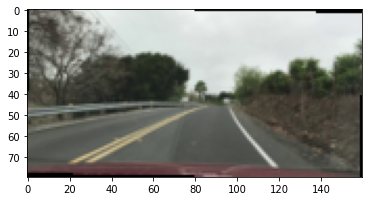

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.array(train_img[2]))

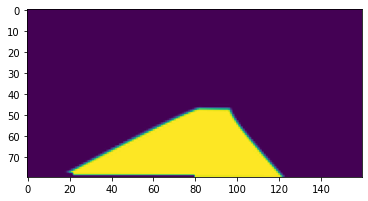

In [ ]:
plt.imshow(np.array(labels[2]).reshape(80,160))

# Creat CNN structure

In [ ]:
def create_model(input_shape, pool_size):
    model = Sequential()
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(Conv2D(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(UpSampling2D(size=pool_size))
    model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(UpSampling2D(size=pool_size))
    model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Conv2DTranspose(1, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))

    return model

In [ ]:
batch_size = 128
epochs = 10
pool_size = (2, 2)
input_shape = X_train.shape[1:]
model = create_model(input_shape, pool_size)
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 80, 160, 3)       12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 78, 158, 8)        224       
                                                                 
 conv2d_1 (Conv2D)           (None, 76, 156, 16)       1168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 38, 78, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 76, 16)        2320      
                                                                 
 dropout (Dropout)           (None, 36, 76, 16)        0

# Train model

In [ ]:
model.compile(optimizer='Adam', loss='mean_squared_error')
history= model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,
                    epochs=epochs, verbose=1, validation_data=(X_val, y_val))
model.trainable = False
model.compile(optimizer='Adam', loss='mean_squared_error')
model.save('lanedetect.h5')


# Load model

In [ ]:
from keras.models import load_model
model =load_model('/content/drive/MyDrive/lane detection/lanedetect.h5')

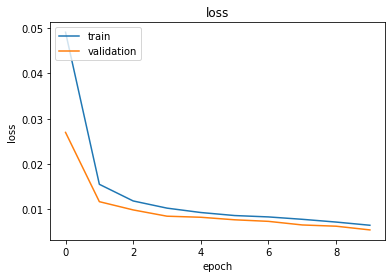

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc = 'upper left')
plt.show()

  



Show random 1 figure

In [ ]:
rand = np.random.randint(1,20)
img = X_val[rand]
img = img[None,:,:,:]
ypred = model.predict(img)[0]
ypred = np.where(ypred<0.5,0,1)*255

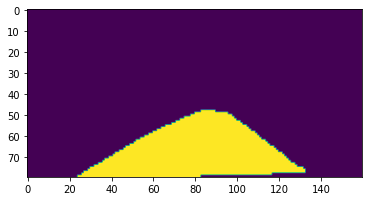

In [ ]:
plt.imshow(np.array(ypred.reshape(80,160)))

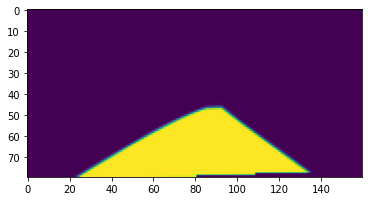

In [ ]:
plt.imshow(np.array(y_val[rand].reshape(80,160)))



Show 8 figures to test model

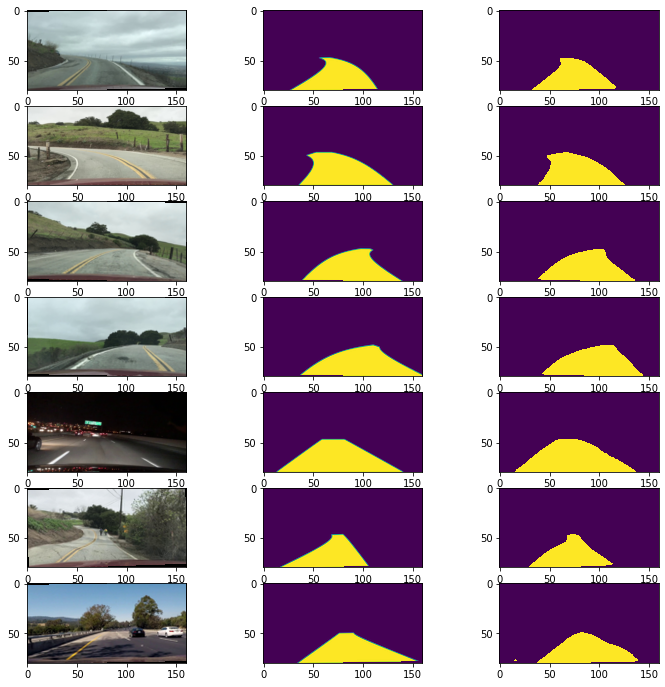

In [ ]:
imgs=[]
for i in range(3,11):
    imgs.append(np.array(X_val[i]))
    
    imgs.append(np.array(y_val[i].reshape(80,160)))

    img= X_val[i]
    img=img[None,:,:,:]
    ypr=model.predict(img)[0] 
    ypr=np.where(ypr<0.5,0,1)*255
    imgs.append(np.array(ypr.reshape(80,160)))
    
_, axs = plt.subplots(7, 3, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [ ]:
pip install scipy==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import cv2
from scipy.misc import imresize
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from keras.models import load_model
class Lanes():
    def __init__(self):
        self.recent_fit = []
        self.avg_fit = []

def road_lines(image):
    small_img = imresize(image, (80, 160, 3))
    small_img = np.array(small_img)
    small_img = small_img[None,:,:,:]
    prediction = model.predict(small_img)[0] * 255
    lanes.recent_fit.append(prediction)
    if len(lanes.recent_fit) > 5:
        lanes.recent_fit = lanes.recent_fit[1:]
    lanes.avg_fit = np.mean(np.array([i for i in lanes.recent_fit]), axis = 0)
    blanks = np.zeros_like(lanes.avg_fit).astype(np.uint8)
    lane_drawn = np.dstack((blanks, lanes.avg_fit, blanks))
    lane_image = imresize(lane_drawn, (720, 1280, 3))
    result = cv2.addWeighted(image, 1, lane_image, 1, 0)

    return result
model = load_model('/content/drive/MyDrive/lane detection/lanedetect.h5')
lanes = Lanes()
vid_output = 'Video_after_process2.mp4' #output video
vid_input = VideoFileClip("/content/drive/MyDrive/lane detection/project_video.mp4") #Input video
vid_clip = vid_input.fl_image(road_lines)
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video Video_after_process2.mp4
[MoviePy] Writing video Video_after_process2.mp4


100%|█████████▉| 1260/1261 [02:19<00:00,  9.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Video_after_process2.mp4 

CPU times: user 1min 51s, sys: 6 s, total: 1min 57s
Wall time: 2min 20s


In [ ]:
pip install streamlit -q

In [ ]:
pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def video(videoup):
  video_pre = VideoFileClip(video)
  return video_pre


In [ ]:
%%writefile app.py
import streamlit as st
def uploadFile():
      vid_file = st.file_uploader("Upload a video", type=["mp4", "mov","avi"])
      tempVideo = tempfile.NamedTemporaryFile(delete=False) 
      if vid_file is not None: 
        tempVideo.write(vid_file.read())
      return tempVideo.name
            

Overwriting app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

2022-06-21 11:25:35.559 INFO    numexpr.utils: NumExpr defaulting to 2 threads.
npx: installed 22 in 2.368s

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.86.43.120:8501

your url is: https://poor-eyes-bathe-34-86-43-120.loca.lt
/root/.npm/_npx/1373/lib/node_modules/localtunnel/bin/lt.js:81
    throw err;
    ^

Error: connection refused: localtunnel.me:37267 (check your firewall settings)
    at Socket.<anonymous> (/root/.npm/_npx/1373/lib/node_modules/localtunnel/lib/TunnelCluster.js:52:11)
    at Socket.emit (events.js:315:20)
    at emitErrorNT (internal/streams/destroy.js:106:8)
    at emitErrorCloseNT (internal/streams/destroy.js:74:3)
    at processTicksAndRejections (internal/process/task_queues.js:80:21)
  Stopping...
